# Hurst Exponent Estimation

### Introduction
The [hurst exponent (HE)](https://en.wikipedia.org/wiki/Hurst_exponent) is a measure of the autocorrelation or self similarity of a signal. It is also related to fractional dimensions (D; with D = 2 - HE). Most naturally occuring signals are not pure gaussian (HE=0.5), but are rather fractionally gaussian with positive autocorrelations (HE > 0.5) or negative autocorrelation (HE < 0.5).

### Goal of this notebook
Explore two methods of measuring HE. The first is [Detrended Fluctuation Analysis (DFA)](https://en.wikipedia.org/wiki/Detrended_fluctuation_analysis) which has the advantage of not requiring stationary data, but requires long timeseries. The other method is meant to be robust to shorter timeseries, and we name it the [1:Nth order autoCorrelation Analysis (NCA)](https://doi.org/10.1007/s11760-018-1353-2). To compare these methods, we implemented them along with two data generating processes, [one which uses the powerlaw in the frequency domain](https://ieeexplore.ieee.org/document/381848) and [the other which uses exponent circulant embedding](https://arxiv.org/pdf/1308.0399v1.pdf). We can then generate data and test which HE estimation is best suited for short timeseries. Once this is determined, we can use this method on short timeseries such as fMRI signal during task execution or discuss other explore effects of HE on our interpretation of biological signals.

### Results
NCA is a more reliable metric but is not valid for all data generating processes. Knowing the functional relation between the NCA measurement and the aspect of HE we want to measure allows us to bypass this problem. NCA is better than DFA on short timeseries.

## Imports

In [1]:
import sys
import time
sys.path.append('..')

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
%matplotlib inline

import numpy as np
import sklearn
from scipy import stats
import hest
np.random.seed(0)

## Why does HE matter?
First of all, metrics like HE may be useful as a marker of timeseries signals, and have already been used in [neural signal processing](https://doi.org/10.3389/fphys.2020.00827) and in [cardiac signal processing](https://aip.scitation.org/doi/10.1063/1.5038818), for example. However, one issue is that the HE may modulate other metrics such as between-region correlations (often used in fMRI functional connectivity analyses), even though the source of the HE can be entirely local and independent of between region interactions. We try to demonstrate this below.

In [20]:
#creating timeseries with 2 different methods
num_els = 100    #number of timeseries
nr_samples = 100  #samples per timeseries
alpha = np.arange(.1,1,0.1)  #setting a range of hurst exponents to create timeseries over

X = np.zeros((len(alpha),num_els,nr_samples)) #timeseries list 1
X2 = np.copy(X)  #timeseries list 2
for ii in np.arange(0,alpha.shape[0]):
    for jj in range(num_els):
        X[ii,jj,:] = hest.tools.simulate_ts_by_powerlaw(nr_samples,alpha[ii])
for ii in np.arange(0,alpha.shape[0]):
    for jj in range(num_els):
        X2[ii,jj,:] = hest.tools.simulate_ts_by_exponent_ce(nr_samples,alpha[ii])

In [21]:
X_corr = np.zeros((len(alpha)*num_els, len(alpha)*num_els))
for ii,ts1 in enumerate(X2.reshape((len(alpha)*num_els,nr_samples))):
    for jj,ts2 in enumerate(X2.reshape((len(alpha)*num_els,nr_samples))):
        X_corr[ii,jj] = np.corrcoef(ts1,ts2)[1,0]

In [22]:
X_corr = np.abs(X_corr.reshape((len(alpha), num_els, len(alpha)*num_els)))
X_corr = X_corr.sum(axis=1)
X_corr = X_corr.reshape((len(alpha), len(alpha), num_els))
X_corr = X_corr.sum(axis=2) 
np.fill_diagonal(X_corr, (X_corr.diagonal()-num_els)*(num_els+1)/num_els)
# X_corr = X_corr.sum(axis=2) - num_els     # subtract num_els because there each timeseries is correlated to itself once
X_corr = X_corr / (num_els*num_els - num_els)

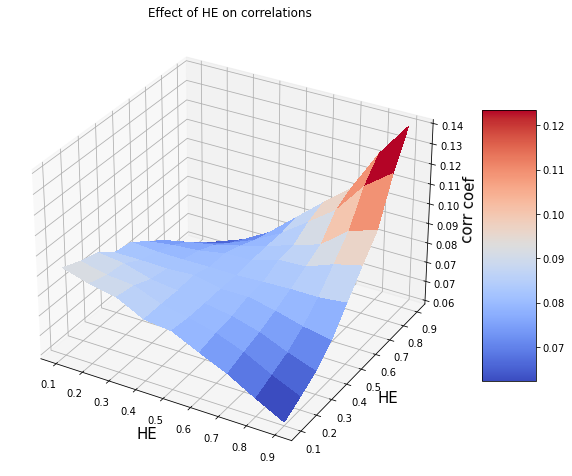

In [30]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))

# Plot the surface.
X_grid, Y_grid = np.meshgrid(alpha, alpha)
surf = ax.plot_surface(X_grid, Y_grid, X_corr, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
ax.zaxis.set_label_text('corr coef',size=15)
ax.xaxis.set_label_text('HE',size=15)
ax.yaxis.set_label_text('HE',size=15)
ax.set_title('Effect of HE on correlations')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

The 3D plot above shows that the Hurst exponent can affect spurious correlations, even when the timeseries were generated independently. More specifically, similar HE between both timeseries increased correlation, with strongest correlations occuring when both HEs were high

## Generating timeseries using two methods 

In [6]:
#creating timeseries with 2 different methods
num_els = 5000    #number of timeseries
nr_samples = 1000  #samples per timeseries
alpha = np.arange(.3,1,0.01)  #setting a range of hurst exponents to create timeseries over
alphas = np.array([alpha[np.random.randint(alpha.shape[0])] for ii in np.arange(num_els)])

X = np.zeros((num_els,nr_samples)) #timeseries list 1
X2 = np.copy(X)  #timeseries list 2
for idx in np.arange(0,X.shape[0]):
#     alpha = alphas[idx]
    X[idx,:] = hest.tools.simulate_ts_by_powerlaw(nr_samples,alphas[idx])
for idx in np.arange(0,X2.shape[0]):
#     alpha = alphas[idx]
    X2[idx,:] = hest.tools.simulate_ts_by_exponent_ce(nr_samples,alphas[idx])

Text(0.5, 1.0, 'Example high hurst exponent (exponent method)')

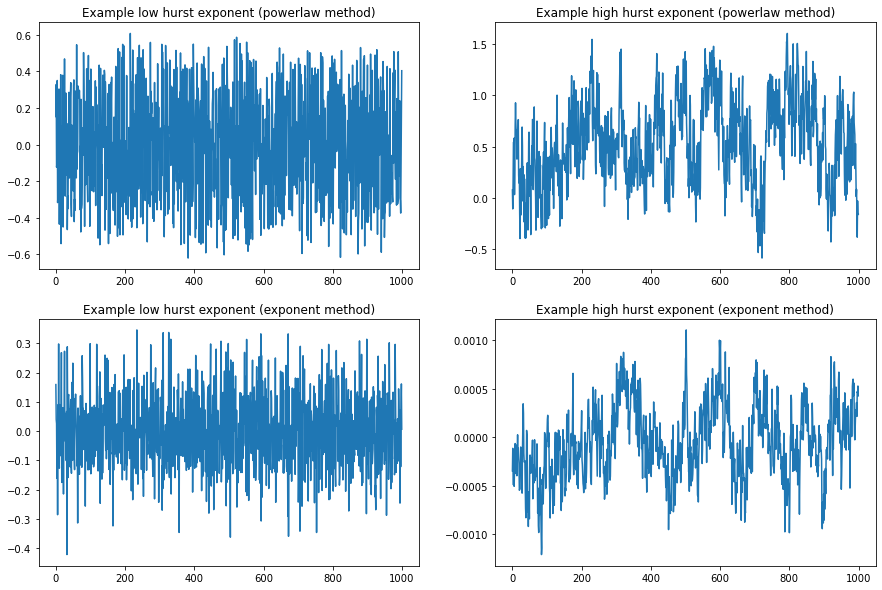

In [7]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(X[np.argmin(alphas)])
plt.title('Example low hurst exponent (powerlaw method)')

plt.subplot(2, 2, 2)
plt.plot(X[np.argmax(alphas)])
plt.title('Example high hurst exponent (powerlaw method)')

plt.subplot(2, 2, 3)
plt.plot(X2[np.argmin(alphas)])
plt.title('Example low hurst exponent (exponent method)')

plt.subplot(2, 2, 4)
plt.plot(X2[np.argmax(alphas)])
plt.title('Example high hurst exponent (exponent method)')

The plots above show low (left) vs high (right) Hurst Exponent time series. This is a demonstration of the effect of changing signal autocorrelation, where high HE ( > 0.5 ) values have positive autocorrelation, while lower values ( < 0.5 ) have negative autocorrelation

## Measuring HE using DFA and NCA

In [8]:
#testing with dfa
HEdfa1=hest.dfa.dfa_blocked(X,min_samples=10,max_samples=250,num_window_steps=10,by_voxel_group=None)['HE']
HEdfa2=hest.dfa.dfa_blocked(X2,min_samples=10,max_samples=250,num_window_steps=10,by_voxel_group=None)['HE']

No header / affine in img input, treating as array
Don't be lazy, provide a mask please.
... in the meantime, using non-zero data from first volume to create mask.
... just because I like you!

Sample sizes per window were calculated based on min_samples, max_samples, and num_window_steps
Number of window steps used in this dataset: 10
Iterating over 1 3d blocks of data, with a total of 1000 sample timepoints
Performing dfa with 10 sets of windows:
	Input data dimensions:			(5000, 1000)
	Number of windows used for HE calc:	[100  71  50  34  24  17  12   8   6   4]
	Number of samples in each window:	[10.00, 14.08, 20.00, 29.41, 41.67, 58.82, 83.33, 125.00, 166.67, 250.00]

  Time for window variance calculations in block 1: 1.27s for 10 windows
	Mean non-zero HE: 			0.639 
	Mean non-zero R2 fit: 			0.992 
Total time for HE calc: 1.27s

No header / affine in img input, treating as array
Don't be lazy, provide a mask please.
... in the meantime, using non-zero data from first volume to cr

In [9]:
#testing with nca.
start = time.time()
HEnca1= hest.nca.nca(X[:,:], seg_l=20, useOddsOnly=False, resolution = 0.01, useMeanCov=True)
end = time.time()
print("Elapsed  = %s" % (end - start))

start = time.time()
HEnca2 = hest.nca.nca(X2[:,:], seg_l=20, useOddsOnly=False, resolution = 0.01, useMeanCov=True)
end = time.time()
print("Elapsed  = %s" % (end - start))


getting dBB matrix from timeseries matrix
get mxn matrix of m timeseries with n autocorrs (for n timestep jumps)
get mxn matrix of true (theoretical) autocorrs where m=hurst n=distance for autocorr
Optimize over H's
Elapsed  = 4.953687906265259
getting dBB matrix from timeseries matrix
get mxn matrix of m timeseries with n autocorrs (for n timestep jumps)
get mxn matrix of true (theoretical) autocorrs where m=hurst n=distance for autocorr
Optimize over H's
Elapsed  = 4.892028570175171


## Plotting HE values and residuals

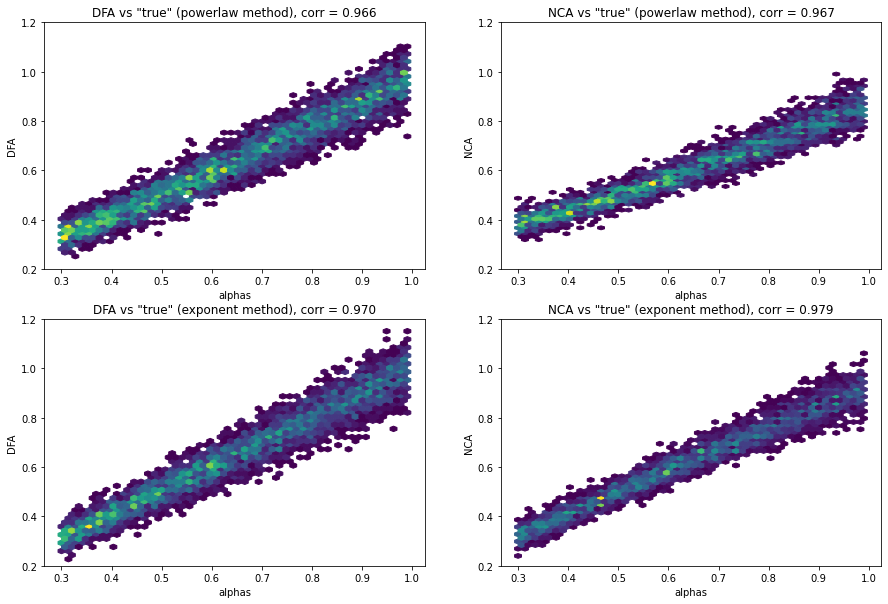

In [10]:
fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hexbin(alphas,HEdfa1,mincnt=1,gridsize=50)
plt.ylim([.2,1.2])
plt.xlabel('alphas')
plt.ylabel('DFA')
plt.title('DFA vs "true" (powerlaw method), corr = ' + str(np.corrcoef(alphas,HEdfa1)[1,0])[:5])

plt.subplot(2, 2, 2)
plt.hexbin(alphas,HEnca1,mincnt=1,gridsize=50)
plt.ylim([.2,1.2])
plt.xlabel('alphas')
plt.ylabel('NCA')
plt.title('NCA vs "true" (powerlaw method), corr = ' + str(np.corrcoef(alphas,HEnca1)[1,0])[:5])

plt.subplot(2, 2, 3)
plt.hexbin(alphas,HEdfa2,mincnt=1,gridsize=50)
plt.ylim([.2,1.2])
plt.xlabel('alphas')
plt.ylabel('DFA')
plt.title('DFA vs "true" (exponent method), corr = ' + str(np.corrcoef(alphas,HEdfa2)[1,0])[:5])

plt.subplot(2, 2, 4)
plt.hexbin(alphas,HEnca2,mincnt=1,gridsize=50)
plt.ylim([.2,1.2])
plt.xlabel('alphas')
plt.ylabel('NCA')
plt.title('NCA vs "true" (exponent method), corr = ' + str(np.corrcoef(alphas,HEnca2)[1,0])[:5])

plt.show()

The plots above show that the correlation between HE measurement and HE of the data generating process depends on the calculation method and on the data generation method, and the highest correlation was found between the NCA measurement and the exponent method of data generation

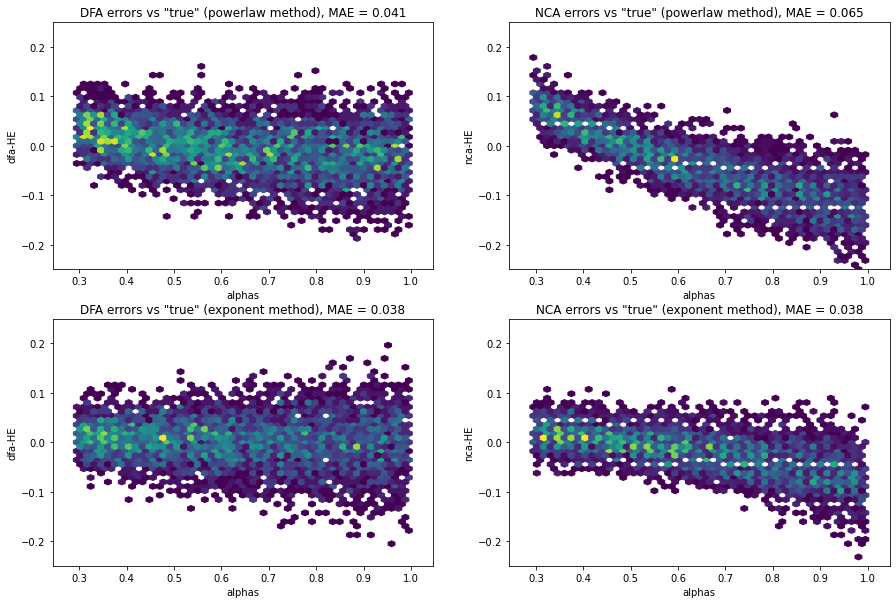

In [11]:

HEdfaError1 = HEdfa1 - alphas
HEncaError1 = HEnca1 - alphas
HEdfaError2 = HEdfa2 - alphas
HEncaError2 = HEnca2 - alphas

fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hexbin(alphas,HEdfaError1,mincnt=1,gridsize=50,extent=(0.28,1.01,-0.25,0.25))
plt.ylim([-0.25,0.25])
plt.xlabel('alphas')
plt.ylabel('dfa-HE')
plt.title('DFA errors vs "true" (powerlaw method), MAE = ' + str(np.mean(np.abs(HEdfaError1)))[:5])

plt.subplot(2, 2, 2)
plt.hexbin(alphas,HEncaError1,mincnt=1,gridsize=50,extent=(0.28,1.01,-0.25,0.25))
plt.ylim([-0.25,0.25])
plt.xlabel('alphas')
plt.ylabel('nca-HE')
plt.title('NCA errors vs "true" (powerlaw method), MAE = ' + str(np.mean(np.abs(HEncaError1)))[:5])

plt.subplot(2, 2, 3)
plt.hexbin(alphas,HEdfaError2,mincnt=1,gridsize=50,extent=(0.28,1.01,-0.25,0.25))
plt.ylim([-0.25,0.25])
plt.xlabel('alphas')
plt.ylabel('dfa-HE')
plt.title('DFA errors vs "true" (exponent method), MAE = ' + str(np.mean(np.abs(HEdfaError2)))[:5])

plt.subplot(2, 2, 4)
plt.hexbin(alphas,HEncaError2,mincnt=1,gridsize=50,extent=(0.28,1.01,-0.25,0.25))
plt.ylim([-0.25,0.25])
plt.xlabel('alphas')
plt.ylabel('nca-HE')
plt.title('NCA errors vs "true" (exponent method), MAE = ' + str(np.mean(np.abs(HEncaError2)))[:5])

plt.show()

The plots above show that NCA has the advantage of being more reliable (lower standard deviation; easier to see in the next plots), but may have lower validity when applied to different data generating processes (as seen by comparing the two right plots). This is unsurprising because DFA is applicable to non-stationary timeseries.

## Performing simple regression improves residuals for NCA

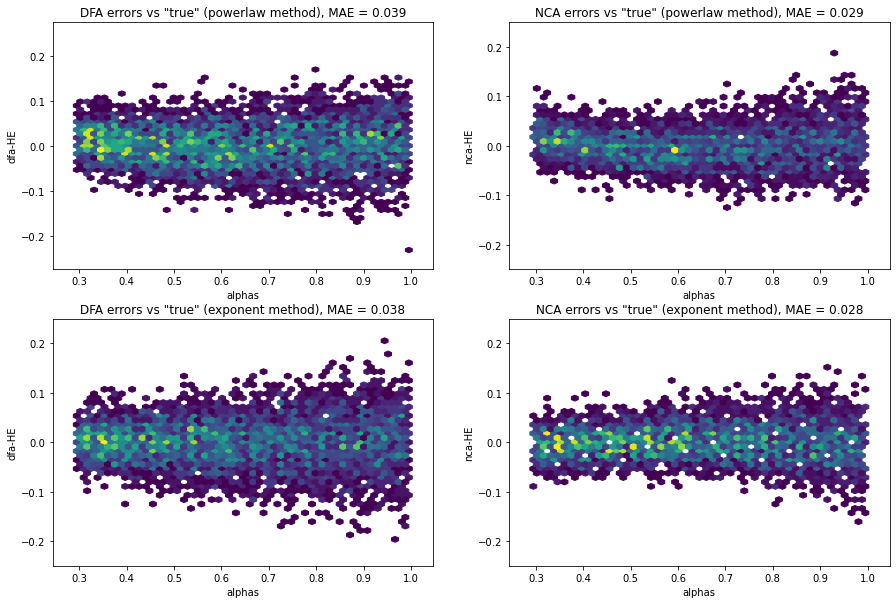

In [12]:
from sklearn.linear_model import LinearRegression
HEdfaError1 = HEdfa1 - LinearRegression().fit(alphas.reshape(-1, 1), HEdfa1).predict(alphas.reshape(-1, 1))
HEncaError1 = HEnca1 - LinearRegression().fit(alphas.reshape(-1, 1), HEnca1).predict(alphas.reshape(-1, 1))
HEdfaError2 = HEdfa2 - LinearRegression().fit(alphas.reshape(-1, 1), HEdfa2).predict(alphas.reshape(-1, 1))
HEncaError2 = HEnca2 - LinearRegression().fit(alphas.reshape(-1, 1), HEnca2).predict(alphas.reshape(-1, 1))

fig = plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hexbin(alphas,HEdfaError1,mincnt=1,gridsize=50,extent=(0.28,1.01,-0.25,0.25))
# plt.ylim([-0.25,0.25])
plt.xlabel('alphas')
plt.ylabel('dfa-HE')
plt.title('DFA errors vs "true" (powerlaw method), MAE = ' + str(np.mean(np.abs(HEdfaError1)))[:5])

plt.subplot(2, 2, 2)
plt.hexbin(alphas,HEncaError1,mincnt=1,gridsize=50,extent=(0.28,1.01,-0.25,0.25))
plt.ylim([-0.25,0.25])
plt.xlabel('alphas')
plt.ylabel('nca-HE')
plt.title('NCA errors vs "true" (powerlaw method), MAE = ' + str(np.mean(np.abs(HEncaError1)))[:5])

plt.subplot(2, 2, 3)
plt.hexbin(alphas,HEdfaError2,mincnt=1,gridsize=50,extent=(0.28,1.01,-0.25,0.25))
plt.ylim([-0.25,0.25])
plt.xlabel('alphas')
plt.ylabel('dfa-HE')
plt.title('DFA errors vs "true" (exponent method), MAE = ' + str(np.mean(np.abs(HEdfaError2)))[:5])

plt.subplot(2, 2, 4)
plt.hexbin(alphas,HEncaError2,mincnt=1,gridsize=50,extent=(0.28,1.01,-0.25,0.25))
plt.ylim([-0.25,0.25])
plt.xlabel('alphas')
plt.ylabel('nca-HE')
plt.title('NCA errors vs "true" (exponent method), MAE = ' + str(np.mean(np.abs(HEncaError2)))[:5])

plt.show()

The use of regression to lower the residuals of NCA suggests that the lower validity of NCA to changing data generating processes can be bypassed if we have knowledge of this process or if we have samples of it.

## Testing degradation of HE measurements with decrease in the length of the timeseries

In [13]:
data_included = np.array([260,300,500,700,1000])  # DFA cannot go below 250, and staying within multiples of 20 for NCA
HE_names = ['HEdfa1', 'HEdfa2', 'HEnca1', 'HEnca2']
HEs = {h: [] for h in HE_names}

for l in data_included:
    #testing with dfa
    HEs['HEdfa1'].append(hest.dfa.dfa_blocked(X[:,:l],min_samples=10,max_samples=250,num_window_steps=10,by_voxel_group=None,verbosity=-1)['HE'])
    HEs['HEdfa2'].append(hest.dfa.dfa_blocked(X2[:,:l],min_samples=10,max_samples=250,num_window_steps=10,by_voxel_group=None,verbosity=-1)['HE'])

    #testing with nca
    HEs['HEnca1'].append(hest.nca.nca(X[:,:l], seg_l=20, useOddsOnly=False, resolution = 0.01, useMeanCov=True, verbose=False))
    HEs['HEnca2'].append(hest.nca.nca(X2[:,:l], seg_l=20, useOddsOnly=False, resolution = 0.01, useMeanCov=True, verbose=False))

In [14]:
HEs_corr = {}
HEs_abserr = {}
HEs_resid = {}

for k in HEs.keys():
    HEs_corr[k] = [np.corrcoef(alphas,hes)[1,0] for hes in HEs[k]]
    HEs_abserr[k] = [np.mean(np.abs(hes - alphas)) for hes in HEs[k]]
    HEs_resid[k] = [np.mean(np.abs(hes - LinearRegression().fit(alphas.reshape(-1, 1), hes).predict(alphas.reshape(-1, 1)))) for hes in HEs[k]]
#     np.mean(np.abs(HEs[k] - alphas))

In [15]:
HEs_resid.keys()

dict_keys(['HEdfa1', 'HEdfa2', 'HEnca1', 'HEnca2'])

In [16]:
HEs_resid['HEdfa1']

[0.07453268066694733,
 0.0699330848167923,
 0.05417197060129736,
 0.04599545982968351,
 0.039286753094749285]

Text(0.5, 1.0, 'HE correlation vs length of timeseries')

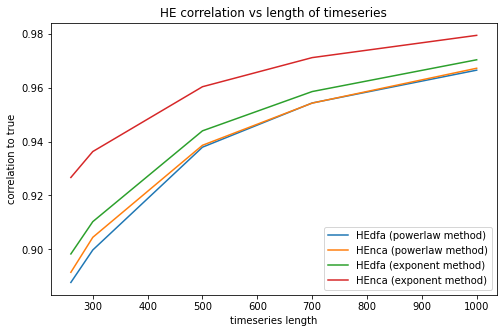

In [17]:
fig = plt.figure(figsize=(8, 5))

p1, = plt.plot(data_included, HEs_corr['HEdfa1'], label='HEdfa (powerlaw method)')
p2, = plt.plot(data_included, HEs_corr['HEnca1'], label='HEnca (powerlaw method)')
p3, = plt.plot(data_included, HEs_corr['HEdfa2'], label='HEdfa (exponent method)')
p4, = plt.plot(data_included, HEs_corr['HEnca2'], label='HEnca (exponent method)')

plt.legend(handles=[p1,p2,p3,p4])
plt.xlabel('timeseries length')
plt.ylabel('correlation to true')
plt.title('HE correlation vs length of timeseries')

Here we see that NCA (exponent method) clearly outperforms all others on the correlation metric, especially at short timeseries lengths.

Text(0.5, 1.0, 'HE MAE vs length of timeseries')

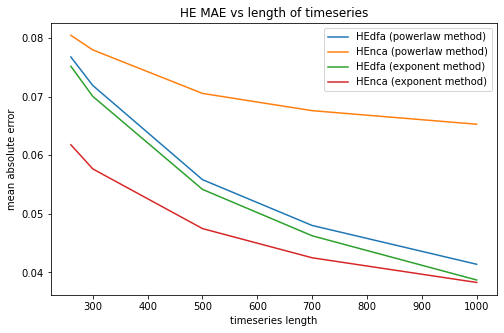

In [18]:
fig = plt.figure(figsize=(8, 5))

p1, = plt.plot(data_included, HEs_abserr['HEdfa1'], label='HEdfa (powerlaw method)')
p2, = plt.plot(data_included, HEs_abserr['HEnca1'], label='HEnca (powerlaw method)')
p3, = plt.plot(data_included, HEs_abserr['HEdfa2'], label='HEdfa (exponent method)')
p4, = plt.plot(data_included, HEs_abserr['HEnca2'], label='HEnca (exponent method)')

plt.legend(handles=[p1,p2,p3,p4])
plt.xlabel('timeseries length')
plt.ylabel('mean absolute error')
plt.title('HE MAE vs length of timeseries')

Another metric (MAE from "ground truth" HE) shows that NCA performance depends greatly on the data generation process

Text(0.5, 1.0, 'HE regression residual MAE vs length of timeseries')

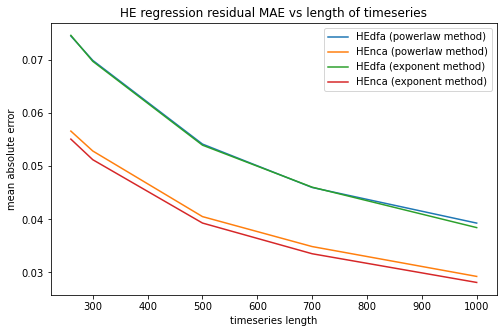

In [19]:
fig = plt.figure(figsize=(8, 5))

p1, = plt.plot(data_included, HEs_resid['HEdfa1'], label='HEdfa (powerlaw method)')
p2, = plt.plot(data_included, HEs_resid['HEnca1'], label='HEnca (powerlaw method)')
p3, = plt.plot(data_included, HEs_resid['HEdfa2'], label='HEdfa (exponent method)')
p4, = plt.plot(data_included, HEs_resid['HEnca2'], label='HEnca (exponent method)')

plt.legend(handles=[p1,p2,p3,p4])
plt.xlabel('timeseries length')
plt.ylabel('mean absolute error')
plt.title('HE regression residual MAE vs length of timeseries')

Lastly, MAE from the regression line shows that NCA outperforms dfa for all timeseries lengths, especially short ones.